In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data.

# Calculate the date one year from the last date in data set.
import datetime as dt

year_before = dt.date(2017, 8 ,23) - dt.timedelta(days=366)

# Perform a query to retrieve the data (**this is a typo and should say date**) and precipitation scores
sel = [Measurement.date, Measurement.prcp]
results = session.query(*sel).\
    filter(Measurement.date > year_before).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['Date', 'Precipitation']).set_index(['Date'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by=['Date']).dropna()
prcp_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


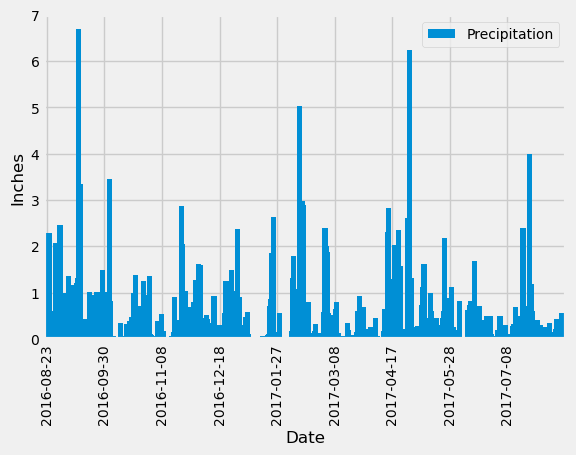

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.bar(figsize=(6,4), width=20)
plt.locator_params(axis='x', nbins=9)
plt.ylim(0,7)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.tick_params(axis='both', labelsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(func.count(Measurement.station.distinct())).all()
number_stations

[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station,(func.count(Measurement.station))).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
summary_temps = session.query(*sel).\
    filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
summary_temps

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

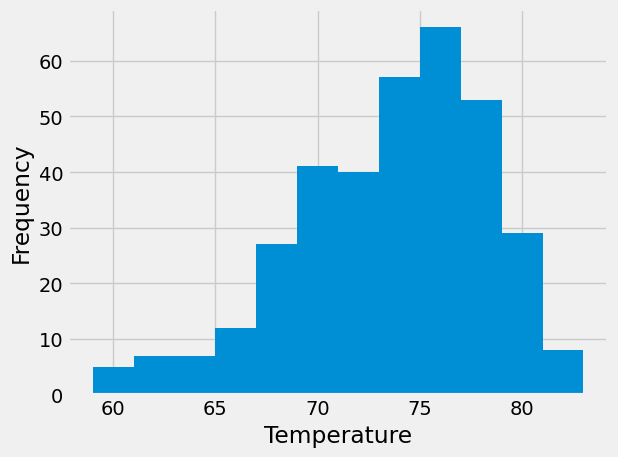

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurement.date, Measurement.tobs]
active_temps = session.query(*sel).\
    filter(Measurement.date > year_before, Measurement.station == "USC00519281").all()


active_temps_df = pd.DataFrame(active_temps, columns=['Date', 'Temperature']).set_index(['Date'])

# Sort the dataframe by date
active_temps_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(active_temps_df, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close session

In [25]:
# Close Session
session.close()